In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
from collections import OrderedDict
from scipy.stats import chisquare
import os
import glob
import feather
from sklearn.linear_model import Ridge
from sequencing_tools.viz_tools import color_encoder, okabeito_palette, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from helper_function import *
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)



def read_count_table(tablename):
    samplename = os.path.basename(tablename).split('.')[0]
    return pd.read_table(tablename, names = ['seq_id','seq_count'])\
        .assign(samplename = samplename)

def read_tgirt():
    tables = glob.glob('../data/*counts')
    #tables = filter(lambda x: re.search('NTT[0-9]+', x), tables)
    df = map(read_count_table,tables)
    return pd.concat(df, axis=0) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
corrected_count = feather.read_dataframe('../results/corrected_count.feather') \
    .drop(['index','prep'], axis=1) 
corrected_count.head()

,seq_id,samplename,seq_count
0,EBV-10,NTT5_noTA (Corrected),860.048993
1,EBV-10,MiR_NTM2 (Corrected),1166.487859
2,EBV-10,MiR_R3 (Corrected),1236.954534
3,EBV-10,MiR_NTTR2 (Corrected),3020.745932
4,EBV-10,MiR_NTT2 (Corrected),661.598852


In [23]:
get_published(return_count=True).head()

,id,samplename,count,prep_name,cpm
68,EBV-1-1,GSM2478875_sample_EQCleanTag-4_63826_CCGTCC_S4...,1110,CleanTag.Lab5,223.707019
69,EBV-1-2-star,GSM2478875_sample_EQCleanTag-4_63826_CCGTCC_S4...,32,CleanTag.Lab5,6.449211
70,EBV-1-2,GSM2478875_sample_EQCleanTag-4_63826_CCGTCC_S4...,60,CleanTag.Lab5,12.092271
71,EBV-1-3,GSM2478875_sample_EQCleanTag-4_63826_CCGTCC_S4...,621,CleanTag.Lab5,125.155008
72,EBV-1-3P,GSM2478875_sample_EQCleanTag-4_63826_CCGTCC_S4...,5,CleanTag.Lab5,1.007689


In [46]:
tgirt_df = read_tgirt() \
    .pipe(lambda d: pd.concat([corrected_count, d], sort=False)) \
    .assign(prep_name = lambda d: 'TGIRT_' + d.samplename.map(get_label))\
    .assign(prep_name = lambda d: np.where(d.samplename.str.contains('Corrected'), 
                                            d.prep_name + ' (Corrected)',
                                            d.prep_name))\
    .rename(columns = {'seq_id':'id'})\
    .pipe(lambda d: pd.concat([d, 
                               get_published(return_count=True).rename(columns={'count':'seq_count'})], sort=True)) \
    .query('seq_count > 0 ')\
    .reset_index()\
    .assign(cpm = lambda d: d.groupby('samplename').seq_count.transform(count_to_cpm))\
    .assign(log10_cpm = lambda d: np.log10(d.cpm))\
    .pipe(lambda d: d[~d.prep_name.str.contains('Cir.*Corr|noTA|NTTR.*Corr')])
tgirt_df.head()

,index,cpm,id,prep_name,samplename,seq_count,log10_cpm
1,1,694.687386,EBV-10,TGIRT_Diaminopurine (Corrected),MiR_NTM2 (Corrected),1166.487859,2.841789
2,2,754.702263,EBV-10,TGIRT_NTC (Corrected),MiR_R3 (Corrected),1236.954534,2.877776
4,4,482.527807,EBV-10,TGIRT_NTT (Corrected),MiR_NTT2 (Corrected),661.598852,2.683522
5,5,486.826699,EBV-10,TGIRT_NTC (Corrected),MiR_R1 (Corrected),787.597015,2.687374
6,6,661.357715,EBV-10,TGIRT_NTC (Corrected),MiR_R2 (Corrected),1034.000676,2.820436


In [47]:
plot_df = tgirt_df \
    .assign(prep = lambda d: d.prep_name.map(correct_prep))
plot_df.head()

,index,cpm,id,prep_name,samplename,seq_count,log10_cpm,prep
1,1,694.687386,EBV-10,TGIRT_Diaminopurine (Corrected),MiR_NTM2 (Corrected),1166.487859,2.841789,MTT (Corrected)
2,2,754.702263,EBV-10,TGIRT_NTC (Corrected),MiR_R3 (Corrected),1236.954534,2.877776,NTC (Corrected)
4,4,482.527807,EBV-10,TGIRT_NTT (Corrected),MiR_NTT2 (Corrected),661.598852,2.683522,NTT (Corrected)
5,5,486.826699,EBV-10,TGIRT_NTC (Corrected),MiR_R1 (Corrected),787.597015,2.687374,NTC (Corrected)
6,6,661.357715,EBV-10,TGIRT_NTC (Corrected),MiR_R2 (Corrected),1034.000676,2.820436,NTC (Corrected)


In [48]:
plot_df.prep.unique()

array(['MTT (Corrected)', 'NTC (Corrected)', 'NTT (Corrected)',
       '6N-NTTR (Corrected)', 'NTT', 'MTT', 'NTC', '6N-NTTR',
       'CircLigase', 'NTTR', 'CleanTag', 'TruSeq', '4N', 'NEBNext',
       'NEXTflex'], dtype=object)

In [69]:
def depth_plot(plot_df, ax):
    scatter_df = plot_df\
        .query('seq_count > 0')\
        .groupby(['prep','samplename'], as_index=False)\
        .agg({'seq_count':'sum',
             'cpm':'count'}) 

    for prep, prep_df in scatter_df.groupby('prep'):
        alpha = 0.1 if prep == "TruSeq" else 0.8
        ax.scatter(prep_df.seq_count/1e6, 
               prep_df.cpm,
               label = prep, 
               color = prep_encoder[prep],
               alpha = alpha, 
               s = 100)
    
    pat = [mpatches.Patch(color=prep_encoder[lab], label=lab) for lab in sorted(plot_df.prep.unique())]
    ax.legend(handles = pat, frameon=False, fontsize =15, loc = 'lower right')

    ax.hlines(y = 962, xmin = -100, 
              xmax = 1e8, color = 'red')
    ax.set_xlim(0, 35)
    ax.set_xlabel('Sequencing depth (Million)')
    ax.set_ylabel('Number of miRNA with non-zero count')

def cpm_plot(plot_df, ax):
    cpm_df = plot_df \
        .groupby(['prep_name','id','prep'], as_index=False) \
        .agg({'seq_count':'sum'})\
        .assign(cpm = lambda d: d.groupby('prep_name')['seq_count']\
                            .transform(lambda x: 1e6 * x / x.sum()))\
        .assign(log_cpm = lambda d: d.cpm.transform(lambda x: np.log10(x+1))) \
        .assign(error_cpm = lambda d: d.groupby('prep').log_cpm.transform(lambda x: x.median() - 1e6/962)) \
        .sort_values('error_cpm', ascending=False) \
        .pipe(lambda d: d[~d.prep.isin(['MTT (Corrected)','6N-NTTR (Corrected)'])])#,'NTTR (Corrected)'])])

    colors = cpm_df[['prep','error_cpm']].drop_duplicates().prep.map(prep_encoder)
    sns.violinplot(data = cpm_df, 
               x = 'prep', 
                cut = 0 ,
               y = 'log_cpm', 
               palette = colors,
               ax = ax)
    ax.hlines(y = np.log10(1e6/962), xmin = -100, 
          xmax = 1e8, color = 'red')
    xt = ax.set_xticklabels(ax.get_xticklabels(), rotation = 70, ha = 'right', rotation_mode='anchor')
    #xt = [xt.set_color(col) for xt, col in zip(ax.get_xticklabels(), colors)]
    ax.set_yticks(range(0,6))
    yts = ['$10^%i$' %(i) for i in range(0,6)]
    yts = ax.set_yticklabels(yts)
    ax.set_xlabel('small RNA-seq prep')
    ax.set_ylabel('CPM ($log_{10}$)')
    ax.set_xlim(-0.5, len(colors))

In [50]:
plot_df\
    .filter(['prep','samplename'])\
    .drop_duplicates()\
    .groupby('prep', as_index=False)\
    .count()\
    .assign(color = lambda d: d.prep.map(prep_encoder))

,prep,samplename,color
0,4N,24,#D55E00
1,6N-NTTR,1,red
2,6N-NTTR (Corrected),1,red
3,CircLigase,1,#5e0700
4,CleanTag,4,gray
5,MTT,3,red
6,MTT (Corrected),3,red
7,NEBNext,12,#56B4E9
8,NEXTflex,6,#D55E00
9,NTC,3,red


Plotted /stor/work/Lambowitz/cdw2854/miRNA/new_NTT/mirXplore_plot.eps
Plotted /stor/work/Lambowitz/cdw2854/miRNA/new_NTT/mirXplore_plot.png


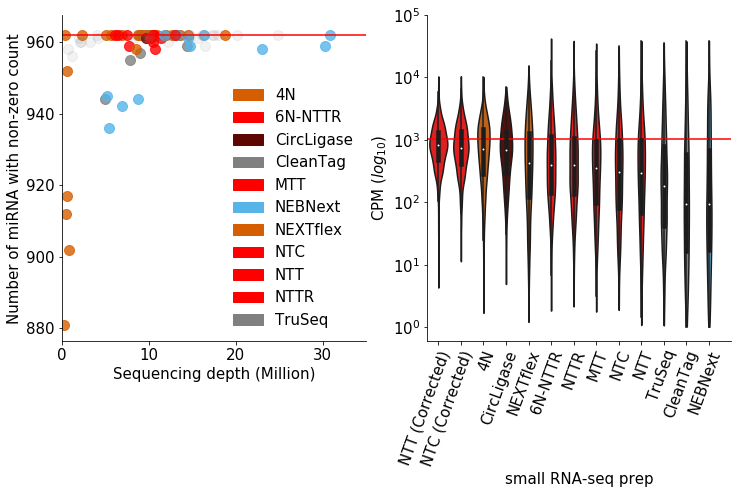

In [70]:
fig = plt.figure(figsize = (12,6))
depth_ax = fig.add_subplot(121)
cpm_ax = fig.add_subplot(122)

depth_plot(plot_df.pipe(lambda d: d[~d.prep.str.contains('Corrected')]), depth_ax)
cpm_plot(plot_df, cpm_ax)
sns.despine()

figurename = figure_path + '/mirXplore_plot.eps'
fig.savefig(figurename, transparent=True, bbox_inches = 'tight')
print('Plotted %s' %figurename)
figurename = figure_path + '/mirXplore_plot.png'
fig.savefig(figurename, transparent=True, bbox_inches = 'tight')
print('Plotted %s' %figurename)

In [71]:
def cumulative_df(plot_df, cutoff =10):
    cum_df = []
    for (prep, samplename), sample_df in plot_df\
            .query('prep!="TGIRT-NTT (Corrected)"')\
            .groupby(['prep','samplename']):
        for frac in np.linspace(0.00001, 1, 1000):
            depth = sample_df.seq_count.sum()
            miRNA_df = sample_df\
                .reset_index()\
                .assign(seq_count = lambda d: d.seq_count * frac )
            new_depth = miRNA_df.seq_count.sum()
            miRNA_count = miRNA_df.query('seq_count > %i' %cutoff)\
                .shape[0]
            cum_df.append((prep, samplename, miRNA_count, depth, new_depth))
            
    return pd.DataFrame(cum_df, 
             columns=['prep','samplename','miRNA_count', 
                    'total_depth','sub_depth']) \
    .assign(depth = lambda d: np.round(d.sub_depth/1e3, decimals=1)) \
    .groupby(['prep','depth','samplename'], as_index=False)\
    .agg({'miRNA_count':'mean'})

In [72]:
#ds = []
#for cutoff in [1, 5, 10]:
#    ds.append(cumulative_df(plot_df, cutoff=10)\
#             .assign(cutoff = cutoff))
#cum_grouped_df = pd.concat(ds)
#cum_grouped_df.to_csv('../data/cumulative_df.tsv', sep='\t', index=False)
#cum_grouped_df.head()

In [74]:
cum_grouped_df = pd.read_table('../data/cumulative_df.tsv')
cum_grouped_df.head()

,prep,depth,samplename,miRNA_count,cutoff
0,4N,0.0,GSM2478874_sample_EQ4NXu-3_63854_CTATAC_S19_L0...,0,1
1,4N,0.0,GSM2478874_sample_EQ4NXu-4_63855_CTCAGA_S20_L0...,0,1
2,4N,0.1,GSM2478867_sample_EQ4NG2-1_63798_CGGAAT_S17_L0...,0,1
3,4N,0.1,GSM2478867_sample_EQ4NG2-2_63799_CTAGCT_S18_L0...,0,1
4,4N,0.1,GSM2478867_sample_EQ4NG2-3_63800_CTATAC_S19_L0...,0,1


In [75]:
def plot_saturation(cum_grouped_df, ax, legend=False, cutoff=10, **kwargs):
    for (prep,sample), p_df in cum_grouped_df \
            .pipe(lambda d: d[~d.prep.str.contains('Corrected')])\
            .groupby(['prep','samplename']):
        #color = prep_encoder[prep]
    
        encoder = {'4N/NEXTflex':prep_encoder['4N'],
                  'NEBNext':prep_encoder['NEBNext'],
                   'TGIRT-NTTR': 'red',
                   'TGIRT-CircLigase':'#5e0700',
                   'TGIRT-seq':'#2d7202',
                  'Other preps':'gray'}
    
        linewidth=1
        if 'NTTR' in prep or 'UMI' in prep:
            color = encoder['TGIRT-NTTR']
            alpha = 1
            linewidth = 2      
        elif re.search('NT[CT]',prep):
            color = encoder['TGIRT-seq']
            alpha = 1
        elif re.search('CircLigase', prep):
            color = encoder['TGIRT-CircLigase']
            alpha = 1
        elif '4N' in prep or 'NEXT' in prep:
            color = encoder['4N/NEXTflex']
            alpha = .7
        elif 'NEB' in prep:
            color = encoder['NEBNext']
            alpha = .5
        else:
            color = encoder['Other preps']
            alpha = 0.2
    
        p_df\
            .sort_values('depth')\
            .plot('depth', 'miRNA_count', 
                  color = color, ax = ax,
                  linewidth = linewidth,
                 label = prep,
                 alpha = alpha)
    
    ax.legend().set_visible(False)
    ax.set_xlim(0,3000)
    ax.set_ylim(0,1000)
    ax.set_xlabel('Read depth (x$10^3$)')
    ax.set_ylabel('Number of detected miRNA\n(> %i read count)' %cutoff)
    ax.hlines(y = 962, xmin=0, xmax=10000, color='red', linestyle=':')
    pat = [mpatches.Patch(color=col, label=lab) for lab, col in encoder.items()]
    if legend:
        ax.legend(handles = pat, frameon=False, **kwargs)

def plot_cum(cum_grouped_df, cutoff=10):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_saturation(cum_grouped_df, ax, cutoff = cutoff)
    axins = fig.add_axes([0.5,0.2,0.4,0.4])
    plot_saturation(cum_grouped_df, axins, legend=True, bbox_to_anchor=(1,0.8), fontsize=12)
    axins.set_xlim(0,500)
    axins.yaxis.set_visible(False)
    axins.set_xlabel('')
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
    sns.despine()
    return fig


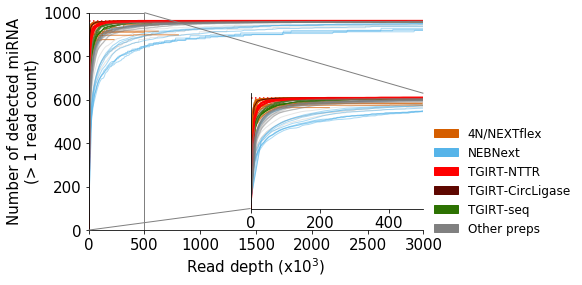

In [76]:
fig = plot_cum(cum_grouped_df.query('cutoff==1'), cutoff=1)
fig.savefig(figure_path + '/saturation_1.png', bbox_inches='tight')

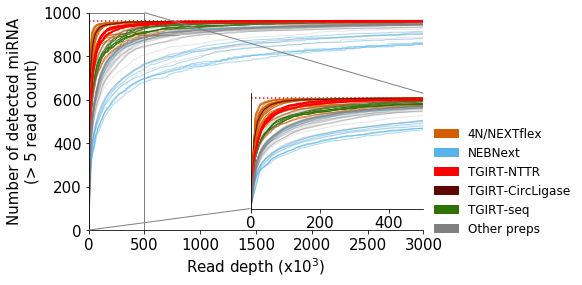

In [77]:
fig = plot_cum(cum_grouped_df.query('cutoff==5'), cutoff=5)
fig.savefig(figure_path + '/saturation_5.png', bbox_inches='tight')

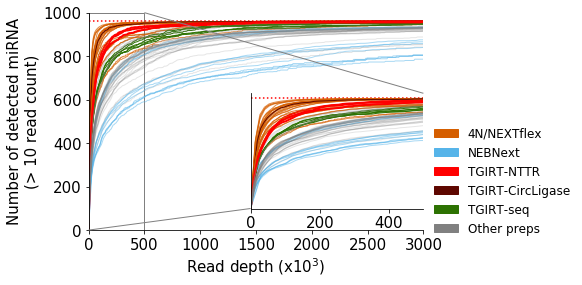

In [78]:
fig = plot_cum(cum_grouped_df.query('cutoff==10'), cutoff=10)
fig.savefig(figure_path + '/saturation_10.png', bbox_inches='tight')

In [79]:
plot_df.groupby('prep').count()

,index,cpm,id,prep_name,samplename,seq_count,log10_cpm
prep,,,,,,,
4N,23088,23088,23088,23088,23088,23088,23088
6N-NTTR,962,962,962,962,962,962,962
6N-NTTR (Corrected),962,962,962,962,962,962,962
CircLigase,961,961,961,961,961,961,961
CleanTag,3815,3815,3815,3815,3815,3815,3815
MTT,2881,2881,2881,2881,2881,2881,2881
MTT (Corrected),2881,2881,2881,2881,2881,2881,2881
NEBNext,11452,11452,11452,11452,11452,11452,11452
NEXTflex,5522,5522,5522,5522,5522,5522,5522


Plotted /stor/work/Lambowitz/cdw2854/miRNA/new_NTT/mirXplore_sat_plot.eps


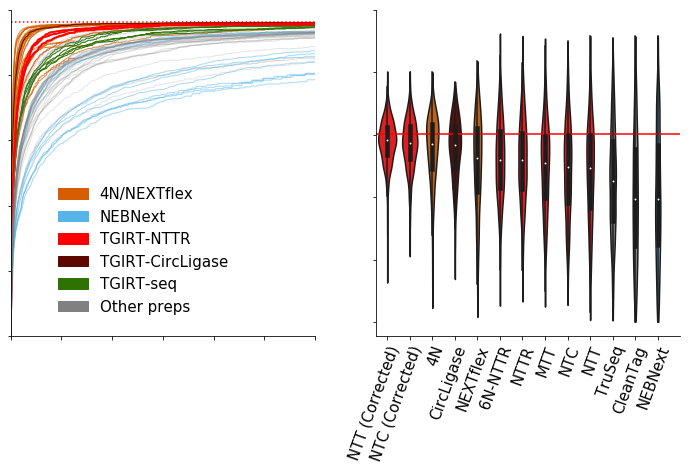

In [80]:
fig = plt.figure(figsize = (12,6))
depth_ax = fig.add_subplot(121)
cpm_ax = fig.add_subplot(122)

cpm_plot(plot_df, cpm_ax)
plot_saturation(cum_grouped_df.query('cutoff==10'), 
                depth_ax, legend=True, 
                bbox_to_anchor = (0.11,0.5), fontsize=15)
depth_ax.xaxis.set_ticklabels([])
depth_ax.yaxis.set_ticklabels([])
depth_ax.set_ylabel('')
depth_ax.set_xlabel('')

cpm_ax.yaxis.set_ticklabels([])
cpm_ax.set_ylabel('')
cpm_ax.set_xlabel('')
sns.despine()

figurename = figure_path + '/mirXplore_sat_plot.eps'
fig.savefig(figurename, transparent=True, bbox_inches = 'tight')
print('Plotted %s' %figurename)
#figurename = figure_path + '/mirXplore_plot.png'
#fig.savefig(figurename, transparent=True, bbox_inches = 'tight')
#print('Plotted %s' %figurename)

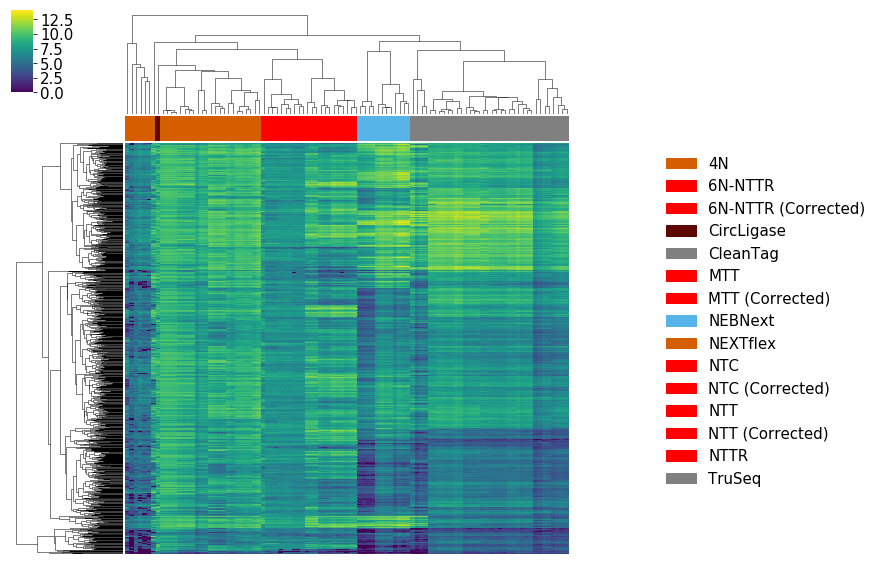

In [81]:
sample_encoder = color_encoder()
sample_encoder.encoder = {}
for i, row in plot_df \
        .filter(['prep_name','samplename','prep']) \
        .drop_duplicates()  \
        .assign(color = lambda d: d.prep.map(prep_encoder)) \
        .iterrows():
    sample_encoder.encoder[row['samplename']] = row['color']

miR_df = plot_df\
    .pipe(pd.pivot_table, columns = 'samplename', 
          values = 'seq_count', index='id', fill_value = 0) \
    .transform(lambda d: np.log(d+1))
    
    
col_color = miR_df.columns.map(sample_encoder.encoder)
p = sns.clustermap(miR_df, cmap = 'viridis', col_colors = list(col_color)) 
pat = [mpatches.Patch(color=prep_encoder[lab], label=lab) for lab in sorted(plot_df.prep.unique())]

ax = p.ax_heatmap
ax.legend(handles = pat, frameon=False, fontsize =15, bbox_to_anchor = (1.7,1))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
p.savefig(figure_path + 'miRNA_heatmap.pdf')

In [82]:
miR_df = plot_df \
    .groupby(['id','prep'], as_index=False)\
    .agg({'seq_count':'sum'})\
    .assign(cpm = lambda d: d.groupby('prep')['seq_count'].transform(count_to_cpm))\
    .pipe(pd.pivot_table, columns = 'prep', 
          values = 'cpm', index='id', fill_value = 0) \
    .transform(lambda d: np.log10(d+1))
miR_df.head()

prep,4N,6N-NTTR,6N-NTTR (Corrected),CircLigase,CleanTag,MTT,MTT (Corrected),NEBNext,NEXTflex,NTC,NTC (Corrected),NTT,NTT (Corrected),NTTR,TruSeq
id,,,,,,,,,,,,,,,
EBV-1-1,3.093298,1.715665,2.851448,3.112661,2.373128,1.413701,2.842024,2.543694,3.154426,1.315482,2.765083,1.105426,2.616160,1.710614,2.858822
EBV-1-2,2.929860,2.736453,2.455279,2.689954,1.407518,2.954700,2.985150,2.490528,2.655153,3.122920,3.163474,3.099210,3.219276,2.805395,1.956109
EBV-1-2-star,2.724229,1.945590,2.326887,1.655899,1.117708,1.874016,2.556502,1.230621,1.698906,1.518428,2.217027,1.872001,2.653786,1.803602,1.269429
EBV-1-3,2.708896,1.771030,2.082556,2.273074,2.013810,2.017860,2.633672,2.356234,1.945015,2.309472,2.950368,2.068659,2.779570,1.673408,1.788986
EBV-1-3P,2.023478,2.823792,2.848198,1.820710,0.371445,2.405090,2.737555,1.479429,2.768221,2.183856,2.528148,2.037127,2.455900,2.907098,1.055383


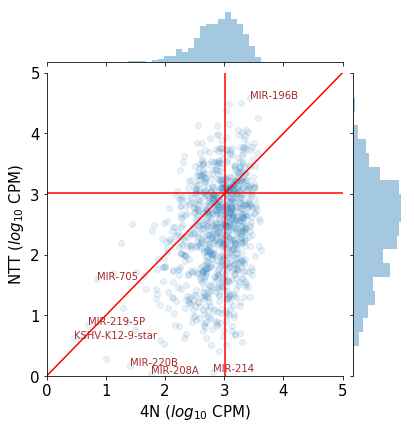

In [83]:
def plot_miRNA_scatter_joint(miR_df, sample_x, sample_y, lab = None):
    p = sns.jointplot(data = miR_df,
        x = sample_x,
        y = sample_y,
        alpha = 0.1)
    for mir, row in miR_df.iterrows():
        if row[sample_y] > 4.5 or row[sample_x] < 1 or row[sample_y] < 0.2 :
            p.ax_joint.text(row[sample_x], row[sample_y], mir, color='brown')
            #print(mir)
    
    p.ax_joint.set_xlim(0,5)
    p.ax_joint.set_ylim(0,5)
    p.ax_joint.axvline(x = np.log10(10**6/962), color = 'red')
    p.ax_joint.axhline(y = np.log10(10**6/962), color = 'red')
    p.ax_joint.plot(range(11), color = 'red')
    p.set_axis_labels('4N ($log_{10}$ CPM)', '%s ($log_{10}$ CPM)' %lab)
    
sample_x = '4N'
sample_y = 'NTT'
sample_y1 = 'NTT (Corrected)'    
plot_miRNA_scatter_joint(miR_df, sample_x, sample_y, lab = 'NTT')

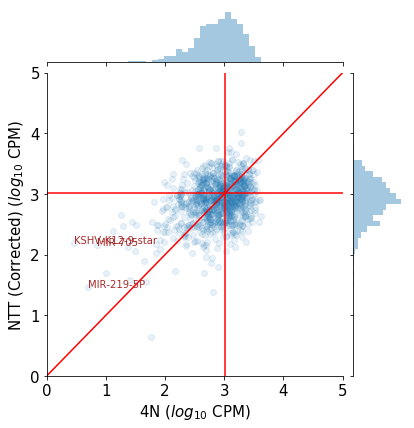

In [84]:
plot_miRNA_scatter_joint(miR_df, sample_x, sample_y1, lab = 'NTT (Corrected)')

In [85]:
sample_x = '4N'
sample_y = 'NTT'
sample_y1 = 'NTT (Corrected)'


def plot_corr_miRNA(miR_df, sample_x, sample_y, ax, s=10, lab = None, 
                    color_scatter=None, cax=None, label_miRNA=False):
    
    
    if not color_scatter:
        miR_df\
            .plot.scatter(sample_x,
                     sample_y,
                     s = s,
                     ax = ax, alpha=0.1)
    else:
        x = miR_df[sample_x]
        y = miR_df[sample_y]
        s = ax.scatter(x = x,
                 y = y,
                 alpha=0.5, 
                 cmap = 'viridis',
                 s = s,
                 c = miR_df[color_scatter])        
        
        boundary = True
        if boundary:
            mean_x = x.mean()
            mean_y = y.mean()
            std_x = x.std() *2
            std_y = y.std() *2
            ax.axvline(x = mean_x-std_x, color = 'purple', linestyle=":")
            ax.axvline(x = mean_x+std_x, color = 'purple', linestyle=":")
            ax.axhline(y = mean_y-std_y, color = 'purple', linestyle=":")
            ax.axhline(y = mean_y+std_y, color = 'purple', linestyle=":")

        if cax:
            cb = plt.colorbar(s, cax = cax)
        else:
            cb = plt.colorbar(s)

    if label_miRNA:
        for mir, row in miR_df.iterrows():
            if row[sample_y] > 4.5 or row[sample_x] < 1 or row[sample_y] < 0.2 :
                ax.text(row[sample_x], row[sample_y], mir, color='brown')
    
    ax.set_xlim(0,5)
    ax.set_ylim(0,5)
    ax.axvline(x = np.log10(10**6/962), color = 'red')
    ax.axhline(y = np.log10(10**6/962), color = 'red')
    ax.plot(range(11), color = 'red')
    ax.set_xlabel('4N ($log_{10}$ CPM)')
    ax.set_ylabel('%s ($log_{10}$ CPM)' %lab)
    sns.despine()
    if color_scatter:
        return cb


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


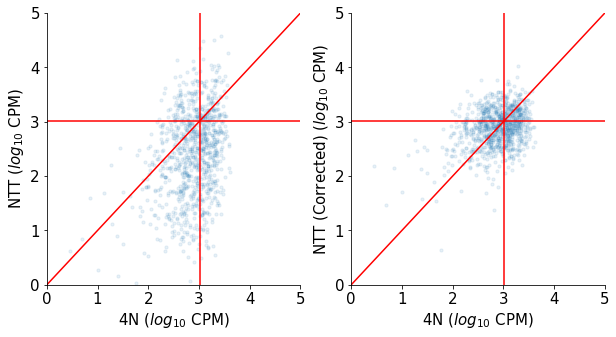

In [23]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plot_corr_miRNA(miR_df, sample_x, sample_y, ax = ax, lab = 'NTT')

ax = fig.add_subplot(122)
plot_corr_miRNA(miR_df, sample_x, sample_y1, ax =ax, lab = 'NTT (Corrected)')

figurename = figure_path + '/scatter_miRNA.eps'
fig.savefig(figurename)

In [87]:
import RNA
import pysam
from Bio.SeqUtils import GC 
from sequencing_tools.fastq_tools import reverse_complement
miR_92 = pysam.Fastafile('/stor/work/Lambowitz/ref/Mir9_2/MiRxplorer.fa')

def foldit(seq, return_energy=False):
    adapter1 = 'AATGATACGGCGACCACCGAGATCTACACGTTCAGAGTTCTACAGTCCGACGATC'
    adapter1_rc = reverse_complement(adapter1)
    R2R = 'GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCTT'
    R2R_len = len(R2R)
    
    cDNA = R2R + reverse_complement(seq) 
    ligation_product = cDNA +'&'+ adapter1_rc
    fold, energy = RNA.cofold(ligation_product)
    print_ligation = ''
    print_fold = ''
    for i, (b,f) in enumerate(zip(ligation_product, fold)):
        if R2R_len - 1 == i:
            print_ligation += '%s|' %b
            print_fold += '%s|' %f

        elif b == "&":
            print_fold += '&%s' %f
            print_ligation += b

        else:
            print_ligation+=b
            print_fold += f

    #print('%s\n%s' %(print_ligation, print_fold))
    #print(energy)
    
    fold = print_fold.split('|')[1]
    match = re.search('[)()]([)()]\.*&\.*[)(])[)(]',fold)
    if match:
        fold_pattern = match.group(1)
    else:
        fold_pattern = '.'
    

    return fold_pattern, energy


def get_seq(miR_id):
    seq = miR_92.fetch(miR_id)
    return seq
    

def self_fold(seq):
    seq =  'GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCTT' + reverse_complement(seq)
    fold, energy = RNA.fold(seq)
    return fold, energy

cutoff = np.log10(1e6/962) 
def categorize_miRNA(N4, NTT):
    lab = ''
    if N4 >= cutoff and NTT >= cutoff:
        lab = 'Both over-represented'
    elif N4 >= cutoff and NTT < cutoff:
        lab = 'Only NTT under-represented'
    elif N4 < cutoff and NTT >= cutoff:
        lab = 'Only 4N under-represented'
    elif N4 < cutoff and NTT < cutoff:
        lab = 'Both under-represented'
    return lab

def free_base(ss):
    return np.where(ss=='nan', 0, ss.map(len))

In [88]:
fold_df = miR_df\
    .filter(['4N','NTT', 'NTT (Corrected)'])\
    .assign(seq = lambda d: d.index.map(get_seq))\
    .assign(gc = lambda d: d.seq.map(GC))\
    .assign(length = lambda d: d.seq.map(len))\
    .assign(fold_pattern = lambda d: d.seq.map(foldit))\
    .assign(cofold_energy = lambda d: d.fold_pattern.map(lambda x: x[1]))\
    .assign(fold_pattern = lambda d: d.fold_pattern.map(lambda x: x[0]))\
    .assign(fold_cat = lambda d: d.fold_pattern.str.replace('\.+','..')) \
    .assign(self_fold_energy = lambda d: d.seq.map(RNA.fold))\
    .assign(self_fold_ss = lambda d: d.self_fold_energy.map(lambda x: x[0]))\
    .assign(self_fold_energy = lambda d: d.self_fold_energy.map(lambda x: x[1]))\
    .assign(R2R_self_fold_energy = lambda d: d.seq.map(self_fold))\
    .assign(R2R_self_fold_ss = lambda d: d.R2R_self_fold_energy.map(lambda x: x[0]))\
    .assign(R2R_self_fold_energy = lambda d: d.R2R_self_fold_energy.map(lambda x: x[1]))\
    .assign(self_fold_3 = lambda d: d.self_fold_ss.astype(str).str.extract('\)([\.]+$)', expand=False)\
                                .astype(str).transform(free_base))\
    .assign(self_fold_5 = lambda d: d.R2R_self_fold_ss.astype(str).str.extract('(^[\.]+)\(', expand=False)\
                                .astype(str).transform(free_base))\
    .assign(miRNA_cat = lambda d: list(map(categorize_miRNA, d['4N'], d['NTT (Corrected)'])))
fold_df.head()

prep,4N,NTT,NTT (Corrected),seq,gc,length,fold_pattern,cofold_energy,fold_cat,self_fold_energy,self_fold_ss,R2R_self_fold_energy,R2R_self_fold_ss,self_fold_3,self_fold_5,miRNA_cat
id,,,,,,,,,,,,,,,,
EBV-1-1,3.093298,1.105426,2.616160,TAACCTGATCAGCCCCGGAGTT,54.545455,22,(......&),-30.700001,(..&),-1.8,.((((((........))).))),-15.4,....((((((((.(((((.(.......))).))).))))))))(((...,0,4,Only NTT under-represented
EBV-1-2,2.929860,3.099210,3.219276,TATCTTTTGCGGCAGAAATTGA,36.363636,22,)..&),-27.400000,)..&),0.0,......................,-7.3,......(((((.((....)).)))))....((((((.............,0,6,Only 4N under-represented
EBV-1-2-star,2.724229,1.872001,2.653786,AAATTCTGTTGCAGCAGATAGC,40.909091,22,)........&....),-29.500000,)..&..),-4.0,....(((((....)))))....,-9.2,......(((((.((....)).))))).......((((........)...,4,6,Both under-represented
EBV-1-3,2.708896,2.068659,2.779570,TAACGGGAAGTGTGTAAGCACA,45.454545,22,)..........&....),-28.400000,)..&..),-3.6,.........((((....)))).,-8.1,......(((((.((....)).))))).........((((....)))...,1,6,Both under-represented
EBV-1-3P,2.023478,2.037127,2.455900,TAGCACCGCTATCCACTATGTC,50.000000,22,)..&...),-28.700001,)..&..),-1.5,((((...))))...........,-9.8,((.((((..(((((...((((...............))))..))))...,11,0,Both under-represented


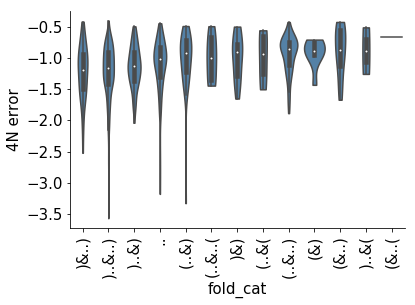

In [89]:
ax = plt.subplot()
edf = fold_df\
    .assign(error = lambda d: d['4N'] - np.log10(10e6/962)) 

x_order = edf\
    .groupby('fold_cat')\
    .agg({'error':'mean'})\
    .sort_values('error')\
    .index.tolist()

sns.violinplot(data = edf, 
               order = x_order, 
               x = 'fold_cat', 
               y = 'error', 
               color= 'steelblue', 
               ax = ax, cut=0)
sns.despine()
ax.set_ylabel('4N error')
xts = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

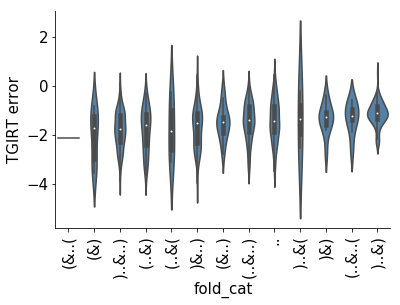

In [90]:
ax = plt.subplot()
edf = fold_df\
    .assign(error = lambda d: d.NTT - np.log10(10e6/962)) 

x_order = edf\
    .groupby('fold_cat')\
    .agg({'error':'mean'})\
    .sort_values('error')\
    .index.tolist()

sns.violinplot(data = edf, order = x_order, x = 'fold_cat', y = 'error', color= 'steelblue', ax = ax)
sns.despine()
ax.set_ylabel('TGIRT error')
xts = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [91]:
from collections import Counter
import pysam
miR_92 = pysam.Fastafile('/stor/work/Lambowitz/ref/Mir9_2/MiRxplorer.fa')
rows = Counter()
for r in miR_92.references:
    seq = miR_92.fetch(r)
    for i in range(3):
        for j in range(3):
            rows["5':N+%i" %(i+1) + seq[i] + ", 3':N-%i" %(j+1) + seq[-(j+1)]] += 1

In [92]:
exp_pos = 962 * 1/16
exp_neg = 962 * 15/16
def chi_pair(pos, neg):
    chi, p = chisquare([pos,neg], [exp_pos, exp_neg])
    return p

def group_p(log_p, return_label = False):
    if log_p <= 3:
        label = '[0-3]'
        fill = 1
    elif log_p <= 10:
        label = '(3-10]'
        fill = 2
    elif log_p <= 20:
        label = '(10-20]'
        fill = 3
    else:
        label = '>20'
        fill = 4
    if return_label:
        return label
    else:
        return fill

p_ce = color_encoder()

chi_df = pd.DataFrame.from_dict(rows, orient='index') \
    .rename(columns = {0:'com_count'}) \
    .assign(neg_count = lambda d: 962-d.com_count)\
    .assign(p = lambda d: list(map(chi_pair, d.com_count, d.neg_count))) \
    .assign(p = lambda d: p_adjust(d.p))\
    .sort_values('p', ascending=False) \
    .assign(log_p = lambda d: -np.log10(d.p))\
    .assign(gp = lambda d: d.log_p.map(group_p))\
    .reset_index()\
    .assign(five_prime = lambda d: d['index'].str.split(',', expand=True).iloc[:,0])\
    .assign(three_prime = lambda d: d['index'].str.split(',', expand=True).iloc[:,1])\
    .pipe(pd.pivot_table, index='five_prime', columns='three_prime', values='gp', aggfunc='sum', fill_value='0<2')
chi_df.head()

three_prime,3':N-1A,3':N-1C,3':N-1G,3':N-1T,3':N-2A,3':N-2C,3':N-2G,3':N-2T,3':N-3A,3':N-3C,3':N-3G,3':N-3T
five_prime,,,,,,,,,,,,
5':N+1A,1,1,1,3,1,1,3,1,1,1,1,2
5':N+1C,2,1,1,1,2,1,1,2,2,2,1,1
5':N+1G,1,2,2,1,2,2,1,2,1,2,1,2
5':N+1T,2,1,2,4,1,2,3,2,1,1,2,4
5':N+2A,2,1,1,3,1,1,3,1,1,1,2,3


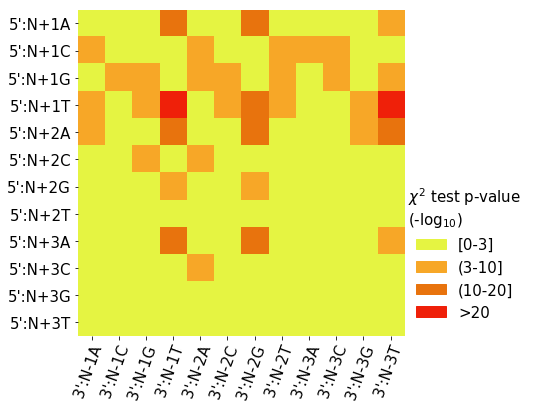

In [93]:
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(6,6))
colors = ['#e5f442','#f7a727','#e8730d','#ef2009']
cmap = ListedColormap(colors, 'myheat')
ax = fig.add_subplot(111)

ax.imshow(chi_df, cmap = cmap)
pat = [mpatches.Patch(color=col, label=lab) for col, lab in zip(colors, [group_p(p,return_label=True) for p in [0,5,12,22]])]
lgd = ax.legend(handles=pat, bbox_to_anchor = (1.4,0.5), fontsize=15,
         title = '$\chi^2$ test p-value\n(-log$_{10}$)',
         frameon=False)
plt.setp(lgd.get_title(),fontsize=15)


ax.set_yticks(range(chi_df.shape[0]))
ax.set_xticks(range(chi_df.shape[1]))
yt = ax.set_yticklabels(chi_df.index)
xt = ax.set_xticklabels(chi_df.columns, rotation=70, ha='right',rotation_mode='anchor')
sp = [ax.spines[sp].set_visible(False) for sp in ['top','bottom','right','left']]
fig.savefig(figure_path + '/miRNA_pvalue.eps', bbox_inches = 'tight')

In [94]:
pd.melt(chi_df)\
    .query('value >= 3')\
    .shape

(10, 2)

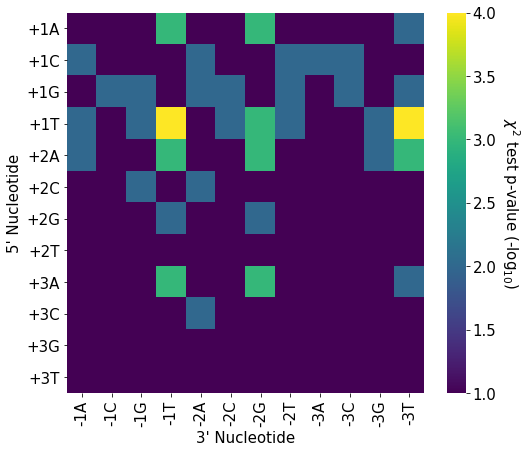

In [95]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
p = sns.heatmap(chi_df,
                    #col_cluster=False, row_cluster=False,
                   #col_colors= col_color.tolist(), row_colors = row_color.tolist() ,
            cmap = 'viridis',
            ax = ax)
ax.set_xlabel("3' Nucleotide")
ax.set_ylabel("5' Nucleotide")
#position_encoder.show_legend(p.ax_col_dendrogram)
p.collections[0].colorbar.set_label('$\chi^2$ test p-value (-log$_{10}$)', rotation=270, va='bottom')


xts = [xt.get_text().split('N')[1] for xt in ax.get_xticklabels()]
yts = [xt.get_text().split('N')[1] for xt in ax.get_yticklabels()]
xts = ax.set_xticklabels(xts)
yts = ax.set_yticklabels(yts)
#fig.text(1,1, r'$\chi^2$  p-val: %.3f' %pval[0])
fig.savefig(figure_path + '/miRNA_pvalue.eps')

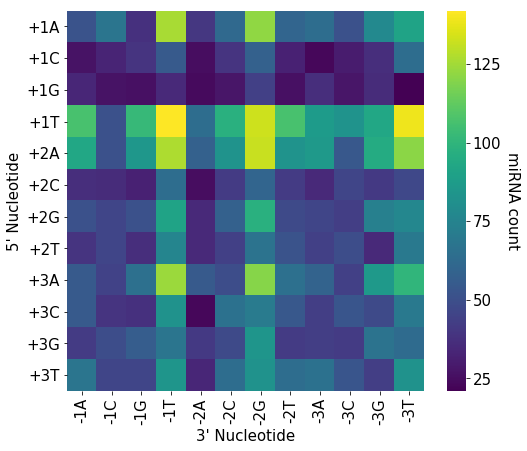

In [96]:
com_df = pd.DataFrame.from_dict(rows, orient='index') \
    .rename(columns = {0:'com_count'}) \
    .reset_index()\
    .assign(five_prime = lambda d: d['index'].str.split(',', expand=True).iloc[:,0])\
    .assign(three_prime = lambda d: d['index'].str.split(',', expand=True).iloc[:,1])\
    .pipe(pd.pivot_table, index='five_prime', columns='three_prime', values='com_count', fill_value=0)
    
chisq, pval = chisquare(com_df.values, axis=None)
position_encoder = color_encoder()
position_encoder.fit(['1','2','3'])

col_color = com_df.columns.map(lambda x: position_encoder.encoder[x[-2]])
row_color = com_df.index.map(lambda x: position_encoder.encoder[x[-2]])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
p = sns.heatmap(com_df,
                    #col_cluster=False, row_cluster=False,
                   #col_colors= col_color.tolist(), row_colors = row_color.tolist() ,
                   cmap = 'viridis',
            ax = ax)
ax.set_xlabel("3' Nucleotide")
ax.set_ylabel("5' Nucleotide")
#position_encoder.show_legend(p.ax_col_dendrogram)
p.collections[0].colorbar.set_label('miRNA count', rotation=270, va='bottom')


xts = [xt.get_text().split('N')[1] for xt in ax.get_xticklabels()]
yts = [xt.get_text().split('N')[1] for xt in ax.get_yticklabels()]
xts = ax.set_xticklabels(xts)
yts = ax.set_yticklabels(yts)
#fig.text(1,1, r'$\chi^2$  p-val: %.3f' %pval[0])
fig.savefig(figure_path + '/miRNA.eps')

In [97]:
pval

7.829402587687132e-286

In [98]:
variable_label = {}
for i,j in zip(['length','gc', 'self_fold_energy',
                'cofold_energy', 'self_fold_3','self_fold_5'],
                ['miRNA size','GC content', 'Self-fold energy\n(kcal/mol)', 
                 'Cofold energy\n(kcal/mol)',"Free nt on 3'\n(Self-fold)", "Free nt on 5'\n(Self-fold)"]):
    variable_label[i] = j

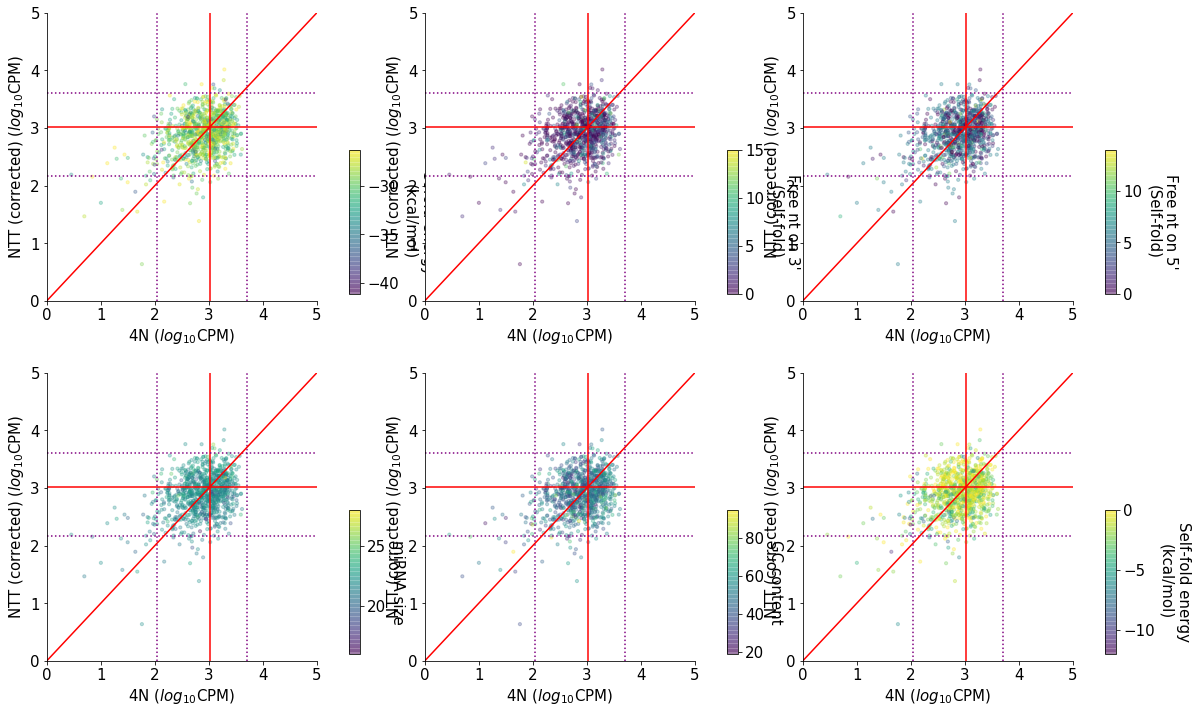

In [99]:
fig = plt.figure(figsize=(15,10))
cats = ['length','gc', 'self_fold_energy','cofold_energy', 'self_fold_3','self_fold_5']
for i, variable in enumerate(cats):
    row = i % 3 + 1
    col = i // 3 + 1
    width = 0.25
    height = 0.4
    row_start = row * 0.35
    row_end = row_start + width
    col_start = col * 0.5
    col_end = col_start + width
    
    ax = fig.add_axes([row_start, col_start, width, height])
    x = fold_df['4N']
    y = fold_df['NTT (Corrected)']
    s = ax.scatter(x = x, 
                   y = y,
           cmap = 'viridis', 
           s = 10,
           c = fold_df[variable],
           alpha=0.3)
    
    variable = variable_label[variable]
    cax = fig.add_axes([row_end + 0.03, col_start + 0.01, 0.01, 0.2])
    cb = plt.colorbar(s, cax = cax)
    cax.yaxis.set_label_position('right')
    cax.set_ylabel(variable, rotation=270, fontsize=15, 
                   va = 'bottom', ha ='center')
    
    #boundary
    mean_x = x.mean()
    mean_y = y.mean()
    std_x = x.std() *2
    std_y = y.std() *2
    ax.axvline(x = mean_x-std_x, color = 'purple', linestyle=":")
    ax.axvline(x = mean_x+std_x, color = 'purple', linestyle=":")
    ax.axhline(y = mean_y-std_y, color = 'purple', linestyle=":")
    ax.axhline(y = mean_y+std_y, color = 'purple', linestyle=":")
    
    ax.vlines(ymin=0,ymax=10, x = np.log10(10**6/962), color = 'red')
    ax.hlines(xmin=0,xmax=10, y = np.log10(10**6/962), color = 'red')
    ax.plot(range(11), color = 'red')
    ax.set_xlim(0,5)
    ax.set_ylim(0,5)
    ax.set_xlabel('4N ($log_{10}$CPM)')
    ax.set_ylabel('NTT (corrected) ($log_{10}$CPM)')
sns.despine()
figurename = figure_path + '/factor_exploration.eps'
fig.savefig(figurename, bbox_inches='tight')

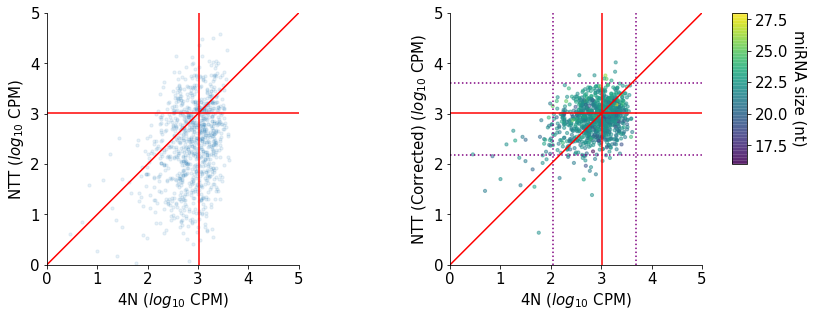

In [100]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0,0.5,0.5,0.5])
plot_corr_miRNA(fold_df, sample_x, sample_y, ax = ax, lab = 'NTT', s= 10)


ax = fig.add_axes([0.8,0.5,0.5,0.5])
cax = fig.add_axes([1.36, 0.7, 0.03, 0.3])
cb = plot_corr_miRNA(fold_df, sample_x, sample_y1, ax =ax, 
                lab = 'NTT (Corrected)', color_scatter='length',
                cax = cax, s = 10, label_miRNA=False)
cax.set_ylabel('miRNA size (nt)', rotation=270, va='bottom')
cax.yaxis.set_ticks_position('right')


#ax = fig.add_axes([0,-0.2,0.5,0.5])
#cax = fig.add_axes([0.59, 0.1, 0.03, 0.3])
#cb = plot_corr_miRNA(fold_df, sample_x, sample_y1, ax =ax, 
#                lab = 'NTT (Corrected)', color_scatter='cofold_energy',
#                cax = cax, s= 10, label_miRNA=False)
#cax.set_ylabel('Cofold energy\n(kcal/mol)', rotation=270, va='bottom')
#cax.yaxis.set_ticks_position('right')



#ax = fig.add_axes([0.8, -0.2,0.5,0.5])
#cax = fig.add_axes([1.29, 0.1, 0.03, 0.3])
#cb = plot_corr_miRNA(fold_df, sample_x, sample_y1, ax =ax, 
#                lab = 'NTT (Corrected)', color_scatter='gc',
#                cax = cax, s= 10, label_miRNA=False)
#cax.set_ylabel('GC content (%)', rotation=270, va='bottom')
#cax.yaxis.set_ticks_position('right')



figurename = figure_path + '/scatter_miRNA.eps'
fig.savefig(figurename, bbox_inches='tight')

In [101]:
def underrepresented_cutoff(x):
    return x.mean() - x.std() * 2

def overrepresented_cutoff(x):
    return x.mean() + x.std() * 2

def label_underrepresented(NTT, N4, ucut_4N, ucut_NTT, ocut_4N, ocut_NTT):
    if N4 < ucut_4N and NTT < ucut_NTT:
        return 'Underrepresented in both'
    elif N4 < ucut_4N:
        return 'Underrepresented in 4N'
    elif NTT < ucut_NTT:
        return 'Underrepresented in NTT'
    elif N4 > ocut_4N and NTT > ocut_NTT:
        return 'Overrepresented in both'
    elif NTT > ocut_NTT:
        return 'Overrepresented in NTT'
    elif N4 > ocut_4N:
        return 'Overrepresented in 4N'
    else:
        return 'Background'

labeled_fold_df = fold_df \
    .assign(NTT_ucut = lambda d: underrepresented_cutoff(d['NTT (Corrected)'])) \
    .assign(N4_ucut = lambda d: underrepresented_cutoff(d['4N']))  \
    .assign(NTT_ocut = lambda d: overrepresented_cutoff(d['NTT (Corrected)'])) \
    .assign(N4_ocut = lambda d: overrepresented_cutoff(d['4N']))\
    .assign(label = lambda d: list(map(label_underrepresented, 
                               d['NTT (Corrected)'], d['4N'],
                              d['N4_ucut'], d['NTT_ucut'],
                              d['N4_ocut'], d['NTT_ocut']))) 
labeled_fold_df.head()

prep,4N,NTT,NTT (Corrected),seq,gc,length,fold_pattern,cofold_energy,fold_cat,self_fold_energy,...,R2R_self_fold_energy,R2R_self_fold_ss,self_fold_3,self_fold_5,miRNA_cat,NTT_ucut,N4_ucut,NTT_ocut,N4_ocut,label
id,,,,,,,,,,,,,,,,,,,,,
EBV-1-1,3.093298,1.105426,2.616160,TAACCTGATCAGCCCCGGAGTT,54.545455,22,(......&),-30.700001,(..&),-1.8,...,-15.4,....((((((((.(((((.(.......))).))).))))))))(((...,0,4,Only NTT under-represented,2.170206,2.040302,3.603969,3.699651,Background
EBV-1-2,2.929860,3.099210,3.219276,TATCTTTTGCGGCAGAAATTGA,36.363636,22,)..&),-27.400000,)..&),0.0,...,-7.3,......(((((.((....)).)))))....((((((.............,0,6,Only 4N under-represented,2.170206,2.040302,3.603969,3.699651,Background
EBV-1-2-star,2.724229,1.872001,2.653786,AAATTCTGTTGCAGCAGATAGC,40.909091,22,)........&....),-29.500000,)..&..),-4.0,...,-9.2,......(((((.((....)).))))).......((((........)...,4,6,Both under-represented,2.170206,2.040302,3.603969,3.699651,Background
EBV-1-3,2.708896,2.068659,2.779570,TAACGGGAAGTGTGTAAGCACA,45.454545,22,)..........&....),-28.400000,)..&..),-3.6,...,-8.1,......(((((.((....)).))))).........((((....)))...,1,6,Both under-represented,2.170206,2.040302,3.603969,3.699651,Background
EBV-1-3P,2.023478,2.037127,2.455900,TAGCACCGCTATCCACTATGTC,50.000000,22,)..&...),-28.700001,)..&..),-1.5,...,-9.8,((.((((..(((((...((((...............))))..))))...,11,0,Both under-represented,2.170206,2.040302,3.603969,3.699651,Underrepresented in 4N


(0, 4)

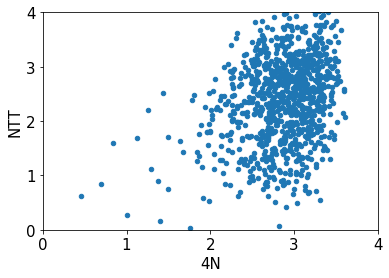

In [102]:
ax = plt.subplot()
fold_df.plot.scatter('4N','NTT', ax= ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)

In [103]:
fold_df.pipe(lambda d: d[(d['4N']<2) & (d['NTT'] < 0.5)])

prep,4N,NTT,NTT (Corrected),seq,gc,length,fold_pattern,cofold_energy,fold_cat,self_fold_energy,self_fold_ss,R2R_self_fold_energy,R2R_self_fold_ss,self_fold_3,self_fold_5,miRNA_cat
id,,,,,,,,,,,,,,,,
MIR-193A-3P,1.000932,0.280615,1.700881,AACTGGCCTACAAAGTCCCAGT,50.000000,22,).&....),-32.299999,)..&..),-4.2,.(((((.((....))..))))),-12.0,......(((((.((....)).))))).........(((((..((.....,0,6,Both under-represented
MIR-208A,1.760735,0.036584,0.636546,ATAAGACGAGCAAAAAGCTTGT,36.363636,22,).....&....),-29.200001,)..&..),-6.1,.....((((((.....)))))),-8.9,......(((((.((....)).))))).........((.(((........,0,6,Both under-represented
MIR-220B,1.398442,0.166942,1.578190,CCACCACCGTGTCTGACACTT,57.142857,21,).&....),-29.000000,)..&..),-2.0,........((((...))))..,-10.1,......(((((.((....)).)))))..(.(((....((((...))...,2,6,Both under-represented


In [104]:
from scipy.stats import ttest_ind, ranksums

def color_pval(p):
    if p < 0.01:
        return 'red'
    elif p <= 0.05:
        return 'blue'
    else:
        return 'black'

def compute_pval(labeled_fold_df, variable):
    rows = []
    for lab, lab_df in labeled_fold_df.groupby('label'):
        x = lab_df[variable].values
        y = labeled_fold_df.query('label == "Background"')[variable].values
        z, p = ttest_ind(x,y)
        w, p = ranksums(x,y)
        rows += [(lab, p)]
    pval_df = pd.DataFrame(rows, columns=['label','pval']) \
        .sort_values('label') \
        .assign(variable = variable)
    
    print(pval_df)
    return {row['label']:row['pval'] for i, row in pval_df.iterrows()}

                      label      pval variable
0                Background  1.000000   length
1    Overrepresented in NTT  0.032263   length
2    Underrepresented in 4N  0.123249   length
3   Underrepresented in NTT  0.012432   length
4  Underrepresented in both  0.114376   length
                      label      pval variable
0                Background  1.000000       gc
1    Overrepresented in NTT  0.435929       gc
2    Underrepresented in 4N  0.555996       gc
3   Underrepresented in NTT  0.914688       gc
4  Underrepresented in both  0.852460       gc
                      label      pval          variable
0                Background  1.000000  self_fold_energy
1    Overrepresented in NTT  0.713451  self_fold_energy
2    Underrepresented in 4N  0.002355  self_fold_energy
3   Underrepresented in NTT  0.116691  self_fold_energy
4  Underrepresented in both  0.477376  self_fold_energy
                      label      pval       variable
0                Background  1.000000  cofold_e

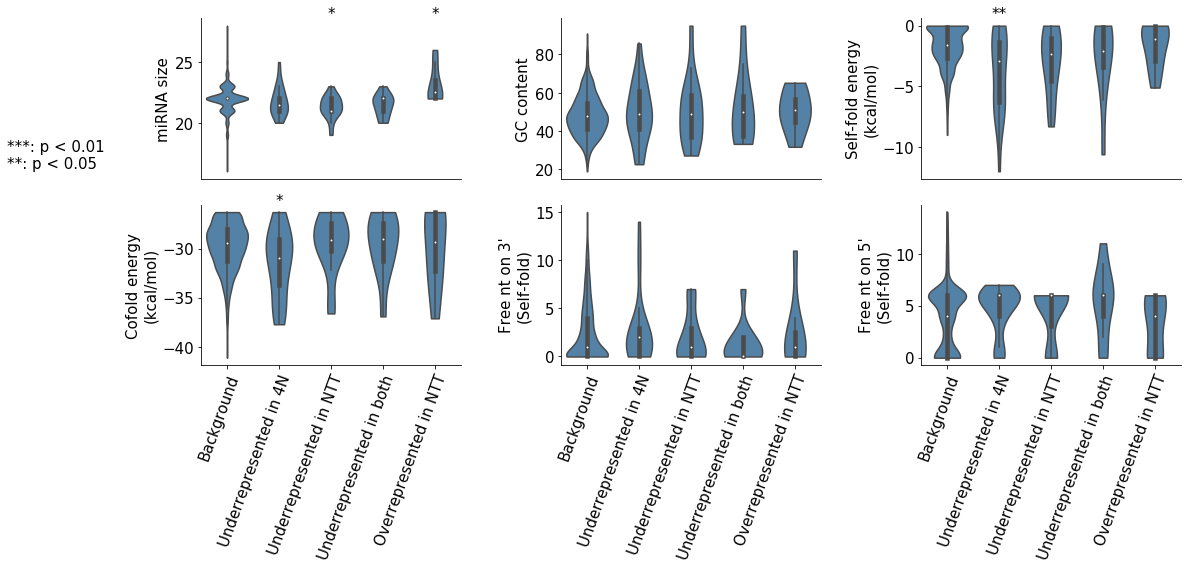

In [105]:
fig = plt.figure(figsize=(15,8))
for i, (variable, var_lab) in enumerate(variable_label.items()):
    ax = fig.add_subplot(2,3,i+1)
    pval_colors = compute_pval(labeled_fold_df, variable)
    
    sns.violinplot(data = labeled_fold_df, 
                  x = 'label', 
                  cut = 0,
                  y = variable, #violin=False,
                  ax = ax, color = 'steelblue')
    ax.set_ylabel(var_lab)
    ax.set_xlabel('')
    
    xtick_position = {}
    for j , xt in enumerate(ax.get_xticklabels()):
        xtick_position[xt.get_text()] = j
        
    ymax = ax.get_ylim()[1]
    for lab, p in pval_colors.items():
        if p < 0.01:
            ax.text(xtick_position[lab], ymax  ,'**', fontsize=15, ha='center')
        elif p < 0.05:
            ax.text(xtick_position[lab], ymax ,'*', fontsize=15, ha='center')
        #elif p < 0.1:
        #    ax.text(xtick_position[lab], ymax ,'*', fontsize=15, ha='center')
    
    if i < 3:
        ax.xaxis.set_visible(False)
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=70,
                  rotation_mode='anchor', ha = 'right')
    
sns.despine()
fig.tight_layout()
fig.text(-0.1,0.7, '***: p < 0.01\n**: p < 0.05', fontsize=15)
fig.savefig(figure_path + '/factor_violin.eps', bbox_inches='tight')

In [106]:
labeled_fold_df.groupby('label').count()

prep,4N,NTT,NTT (Corrected),seq,gc,length,fold_pattern,cofold_energy,fold_cat,self_fold_energy,self_fold_ss,R2R_self_fold_energy,R2R_self_fold_ss,self_fold_3,self_fold_5,miRNA_cat,NTT_ucut,N4_ucut,NTT_ocut,N4_ocut
label,,,,,,,,,,,,,,,,,,,,
Background,901,901,901,901,901,901,901,901,901,901,901,901,901,901,901,901,901,901,901,901
Overrepresented in NTT,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
Underrepresented in 4N,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
Underrepresented in NTT,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
Underrepresented in both,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11


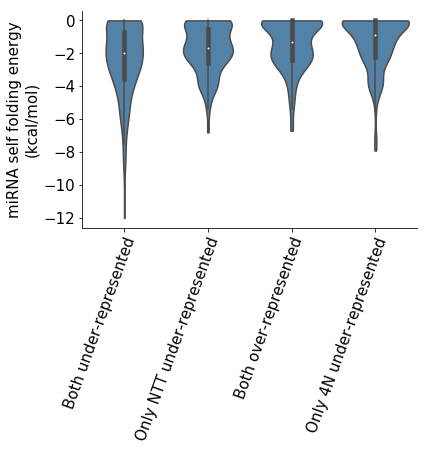

In [107]:
ax = plt.subplot()
fold_df \
    .assign(m = lambda d: d.groupby('miRNA_cat').self_fold_energy.transform(lambda x: x.mean()))\
    .sort_values('m')\
    .pipe(lambda d: sns.violinplot(data=d, x = 'miRNA_cat', y = 'self_fold_energy', ax =ax,
                                  color = 'steelblue', cut = 0)) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=70,
                  rotation_mode='anchor', ha = 'right')
ax.set_ylabel('miRNA self folding energy\n(kcal/mol)')
ax.set_xlabel('')
sns.despine()

In [86]:
fold_df.head()

prep,4N,NTT,NTT (Corrected),seq,gc,length,fold_pattern,cofold_energy,fold_cat,self_fold_energy,self_fold_ss,R2R_self_fold_energy,R2R_self_fold_ss,self_fold_3,self_fold_5,miRNA_cat
id,,,,,,,,,,,,,,,,
EBV-1-1,3.093298,1.105426,2.690099,TAACCTGATCAGCCCCGGAGTT,54.545455,22,(......&),-30.700001,(..&),-1.8,.((((((........))).))),-15.4,....((((((((.(((((.(.......))).))).))))))))(((...,0,4,Only NTT under-represented
EBV-1-2,2.929860,3.099210,3.291079,TATCTTTTGCGGCAGAAATTGA,36.363636,22,)..&),-27.400000,)..&),0.0,......................,-7.3,......(((((.((....)).)))))....((((((.............,0,6,Only 4N under-represented
EBV-1-2-star,2.724229,1.872001,2.593139,AAATTCTGTTGCAGCAGATAGC,40.909091,22,)........&....),-29.500000,)..&..),-4.0,....(((((....)))))....,-9.2,......(((((.((....)).))))).......((((........)...,4,6,Both under-represented
EBV-1-3,2.708896,2.068659,2.743403,TAACGGGAAGTGTGTAAGCACA,45.454545,22,)..........&....),-28.400000,)..&..),-3.6,.........((((....)))).,-8.1,......(((((.((....)).))))).........((((....)))...,1,6,Both under-represented
EBV-1-3P,2.023478,2.037127,2.620463,TAGCACCGCTATCCACTATGTC,50.000000,22,)..&...),-28.700001,)..&..),-1.5,((((...))))...........,-9.8,((.((((..(((((...((((...............))))..))))...,11,0,Both under-represented


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


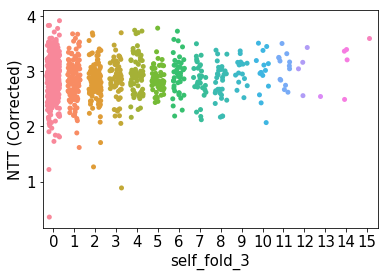

In [87]:
sns.stripplot(data=fold_df, x= 'self_fold_3', y = 'NTT (Corrected)', jitter=0.3)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


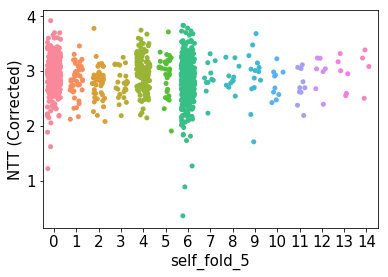

In [88]:
sns.stripplot(data=fold_df, x= 'self_fold_5', y = 'NTT (Corrected)', jitter=0.3)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


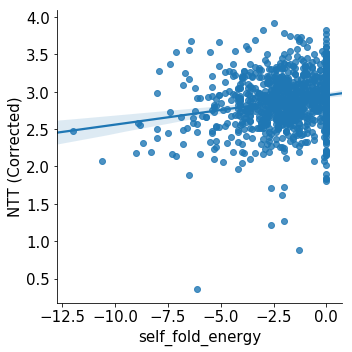

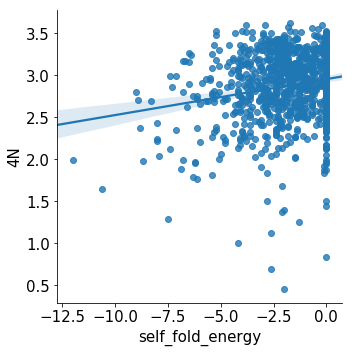

In [89]:
p = sns.lmplot(data=fold_df, x='self_fold_energy', y='NTT (Corrected)')
p = sns.lmplot(data=fold_df, x='self_fold_energy', y='4N')

In [90]:
RNA.fold('TGGCGGCCCGGCCCGGGGCC')

['....(((((......)))))', -10.600000381469727]

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


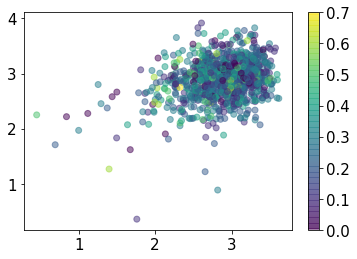

In [91]:
C = fold_df.assign(C = lambda d: d.seq.map(lambda x: Counter(x[:10])['C']/10)) 
plt.scatter(C['4N'], C['NTT (Corrected)'], c = C['C'], alpha=0.5)
plt.colorbar()